> Notebook com o treinamento dos modelos de ML para a classificação do label `vivo_ano3`

---

Segue a base de dados para os tumores do colorretal (C18-C20) com as variáveis relevantes. 

* Para algumas análises, não podemos usar variáveis similares, como EC e EC group ou, se possível, deixar a escolha automática pelo modelo (só especulação rs).

* Gerei uma variável de nome comportamento, na qual só há os número 2 e 3, mas neste momento nos interessa o número 3. ok

* O código da morfologia que iremos trabalhar  será o 81403 (variável MORFO). ok

* Referente a questão da substituição dos valores da variável escolaridade, poderíamos imputar por sexo, idade e estadiamento clínico ao diagnóstico.

# **Bibliotecas e Instalações**

In [ ]:
%%capture 

!pip install shap
!pip install optuna

In [ ]:
seed = 10 # semente para o random_state

# Básicas
import pandas as pd
import numpy as np
import plotly.express as px

# Modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import optuna
from optuna.samplers import RandomSampler
from optuna.visualization import plot_optimization_history

# **Funções**

Para facilitar, foi criado um arquivo separado com todas as funções utilizadas nas análises, por isso, as células abaixo só realizam o download e a importação delas.

In [ ]:
%%capture

!pip install --upgrade --no-cache-dir gdown
!gdown 16uGANHbMsNGzzPq29jY9r4bRBn2k5yGn

In [ ]:
from functions import *

# **Introdução**

**Ideia Geral**

Utilizando os dados de câncer da FOSP, somente do tipo colorretal, serão utilizados quatro modelos de machine learning diferentes, com o intuito de testar diferentes tipos de algoritmo na classificação de sobrevida por três anos.

O label é 0 se o paciente não sobreviveu após três anos do diagnóstico e 1 se sobreviveu.

**Modelos de ML**

Foram escolhidos os modelos Naive Bayes, que utiliza o Teorema de Bayes para realizar as previsões, Random Forest, XGBoost e LightGBM, que utilizam os conceitos de árvores de decisão, além de bagging e boosting. Além disso, será testado um modelo de votação com os melhores classificadores obtidos, visando obter um algoritmo ainda mais acertivo.

**Validação dos modelos**

Para validar os modelos treinados foi utilizada primeiramente a matriz de confusão, sendo possível avaliar os acertos em ambas as classes. Para entender de houve overfitting nos modelos, foi utilizada a curva ROC para os conjuntos de treino e teste, comparando a métrica AUC entre ambos os conjuntos.

Por fim, os modelos Random Forest, XGBoost e LightGBM oferecem a possibilidade de saber quais foram as features mais importantes, ou seja, que mais influenciam na previsão das classes. Assim, foram mostradas duas maneiras diferentes de analisar a importância das variáveis de entrada, uma usando a própria função dos modelos e outra usando a biblioteca SHAP, que mostra a influência das features em ambas as classes.

In [ ]:
# Leitura dos dados
df = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/colorretal_sp_labels.csv')
df.head(3)

(31916, 37)


,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,ECGRUP,TRATHOSP,NENHUM,...,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5,ESCOLARI_2
0,4,19,2,3538709,9,2,IV,IV,I,0,...,3538709,4985,4985,4951,0,0,1,1,1,4.0
1,9,19,1,3537107,2,2,IIIA,III,I,0,...,3509502,2680,2744,2674,1,1,1,1,1,4.0
2,4,19,1,3516200,9,2,IIB,II,F,0,...,3516200,4725,4734,4719,0,0,1,1,1,4.0


In [ ]:
# Valores faltantes
df.isna().sum().sort_values(ascending=False).head(6)

ESCOLARI     0
CONSDIAG     0
DIAGTRAT     0
ANODIAG      0
FAIXAETAR    0
DRS          0
dtype: int64

In [ ]:
# Correlação com a saída
corr_matrix = df.corr()
abs(corr_matrix['vivo_ano3']).sort_values(ascending = False).head(20)

vivo_ano3       1.000000
ULTIDIAG        0.757341
ULTICONS        0.753018
ULTITRAT        0.751754
vivo_ano5       0.698727
vivo_ano1       0.529451
obito_cancer    0.384454
obito_geral     0.370056
ANODIAG         0.230827
CIRURGIA        0.214017
ULTINFO         0.170955
OUTROS          0.079260
IDADE           0.071979
CATEATEND       0.062563
DIAGTRAT        0.048280
RADIO           0.044041
RECNENHUM       0.041957
TRATCONS        0.038209
HORMONIO        0.036303
SEXO            0.034967
Name: vivo_ano3, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df.vivo_ano3.value_counts()

0    18278
1    13638
Name: vivo_ano3, dtype: int64

## **DataFrame vivo_ano3**

Antes de realizar o pré-processamento dos dados é necessário filtrar os dados, de modo a retirar pacientes que não foram acompanhados por pelo menos **três anos** e que a última informação consta como vivos.

In [ ]:
# Dataset da sobrevida de três anos
df_ano3 = df[~((df.obito_geral == 0) & (df.vivo_ano3 == 0))].reset_index(drop=True)
df_ano3.shape

(26231, 37)

In [ ]:
df_ano3.head(3)

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,ECGRUP,TRATHOSP,NENHUM,...,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5,ESCOLARI_2
0,4,19,2,3538709,9,2,IV,IV,I,0,...,3538709,4985,4985,4951,0,0,1,1,1,4.0
1,9,19,1,3537107,2,2,IIIA,III,I,0,...,3509502,2680,2744,2674,1,1,1,1,1,4.0
2,4,19,1,3516200,9,2,IIB,II,F,0,...,3516200,4725,4734,4719,0,0,1,1,1,4.0


# **Análise - Sobrevida três anos**

## **Pré-processamento**

Como o dataset já foi limpo anteriormente, aqui na etapa de pré-processamento serão realizadas a divisão dos dados em treino e teste, a codificação das colunas textuais para colunas numéricas e a normalização dos dados. Com isso, temos os dados prontos para o treinamento dos modelos de machine learning e consequentemente sua validação.

Neste primeiro momento, serão definidas as colunas que não serão utilizadas como features, assim, foi escolhido manter a coluna `IDADE`, então a coluna `FAIXAETAR` será retirada. O mesmo ocorre com a coluna `EC`, retirando a coluna `ECGRUP`. Por fim, as outras colunas contidas na `list_drop` são possíveis saídas para os modelos, mas estamos interessados somente na sobrevida de três anos, por isso só ela será mantida como label e as outras serão retiradas.

In [ ]:
list_drop = ['FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 'obito_geral', 
             'vivo_ano1', 'vivo_ano5', 'ULTINFO', 'obito_cancer', 'ECGRUP', 'ESCOLARI']

lb = 'vivo_ano3'

Uma função foi criada para realizar o pré-processamento inteiro, chamada `preprocessing`, internamente ela utiliza outras funções criadas que são: `get_train_test` (divide os dados em treino e teste), `train_preprocessing` (prepara os dados de treino) e `test_preprocessing` (prepara os dados de teste). 

> Mais detalhes em [funções](https://colorectal.readthedocs.io/en/latest/Fun%C3%A7%C3%B5es.html#Fun%C3%A7%C3%B5es).

In [ ]:
X_train, X_test, y_train, y_test, feat_cols = preprocessing(df_ano3, list_drop, lb, 
                                                            random_state=seed,
                                                            balance_data=False,
                                                            encoder_type='LabelEncoder', 
                                                            norm_name='StandardScaler')

X_train = (19673, 25), X_test = (6558, 25)
y_train = (19673,), y_test = (6558,)


In [ ]:
y_train.value_counts(normalize=True)

1    0.5199
0    0.4801
Name: vivo_ano3, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

1    0.519976
0    0.480024
Name: vivo_ano3, dtype: float64

## **Treinamento e validação dos modelos de machine learning**

Depois das etapas de preparação, os dados estão prontos para serem utilizados nos modelos escolhidos.

### **Naive Bayes**

In [ ]:
# Criação e treinamento do modelo Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

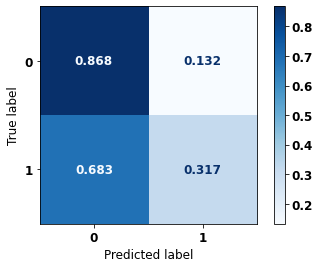


              precision    recall  f1-score   support

           0      0.540     0.868     0.666      3148
           1      0.723     0.317     0.441      3410

    accuracy                          0.582      6558
   macro avg      0.631     0.593     0.553      6558
weighted avg      0.635     0.582     0.549      6558



In [ ]:
# Matriz de confusão
plot_confusion_matrix(nb, X_test, y_test)

> Claramente percebe-se que o modelo previu boa parte dos dados como sendo da classe 0, portanto não teve um aprendizado satisfatório. 

> Na matriz de confusão, buscamos uma diagonal principal equilibrada e com a maior acertividade possível.

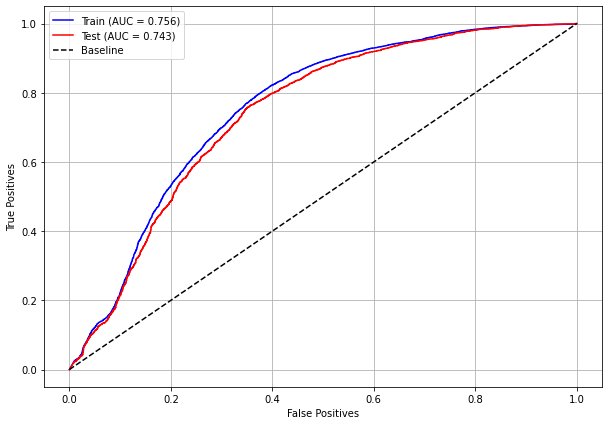

In [ ]:
# Curva ROC
plot_roc_curve(nb, X_train, X_test, y_train, y_test)

> Pelas curvas ROC, pode-se dizer que não há overfitting, mas o modelo é ruim para a previsão da classe 1, portanto qualquer análise além dessa não possui tanta relevância.

### **Random Forest**


O modelo Random Forest é mais complexo em relação ao Naive Bayes, assim alguns hiperparâmetros serão definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

* `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável `seed`.

* `max_depth`: será definido como 8, pois o padrão do modelo é não ter profundidade máxima para as árvores, o que dificulta e faz o treinamento ser muito longo, além da maior chance de overfitting.

* `class_weight`: usado para definir os pesos de cada classe no treinamento do modelo, muito útil quando temos classes desbalanceadas no conjunto de dados, como neste caso.

In [ ]:
# SP 
rf = RandomForestClassifier(random_state=seed, 
                            class_weight={0:1.44, 1:1},
                            max_depth=8,
                            criterion='entropy')

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1.44, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

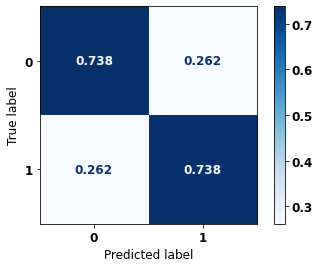


              precision    recall  f1-score   support

           0      0.722     0.738     0.730      3148
           1      0.753     0.738     0.746      3410

    accuracy                          0.738      6558
   macro avg      0.738     0.738     0.738      6558
weighted avg      0.738     0.738     0.738      6558



In [ ]:
plot_confusion_matrix(rf, X_test, y_test)

> A matriz obtida para o modelo Random Forest apresentou diagonal equilibrada em ambas as classes, com 74% de acurácia.


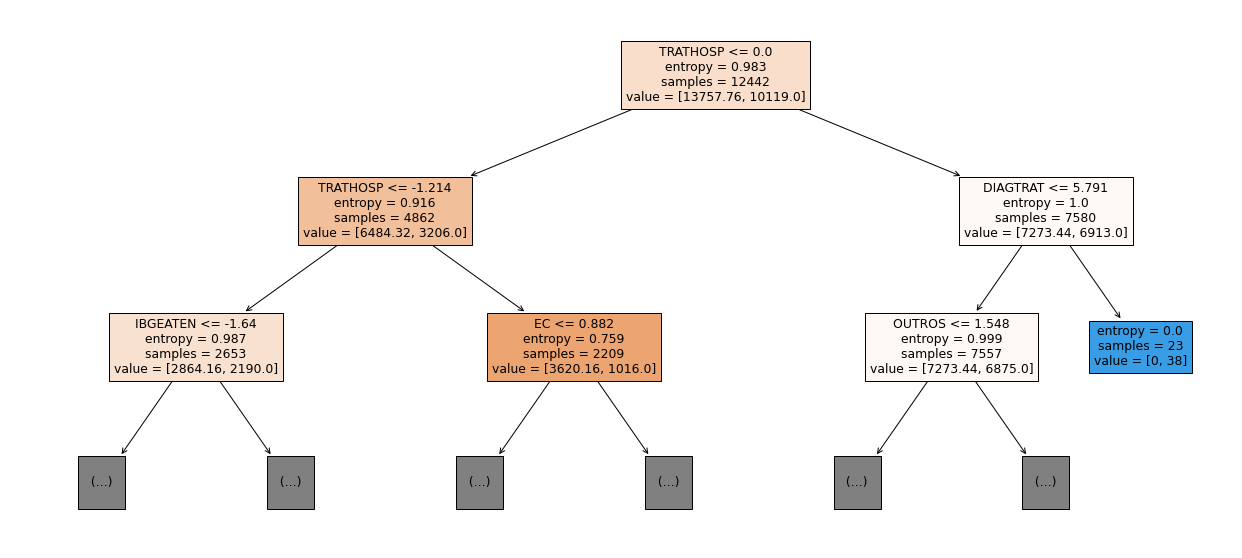

In [ ]:
show_tree(rf, feat_cols, 2)

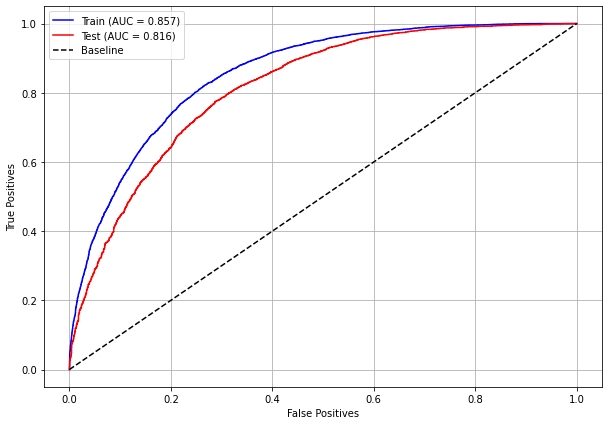

In [ ]:
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

> Como a métrica AUC possui valores próximos para o conjunto de treino e de teste, 0,857 e 0,816 respectivamente, pode-se dizer que há apenas um pouco de overfitting, não sendo algo de grande preocupação.

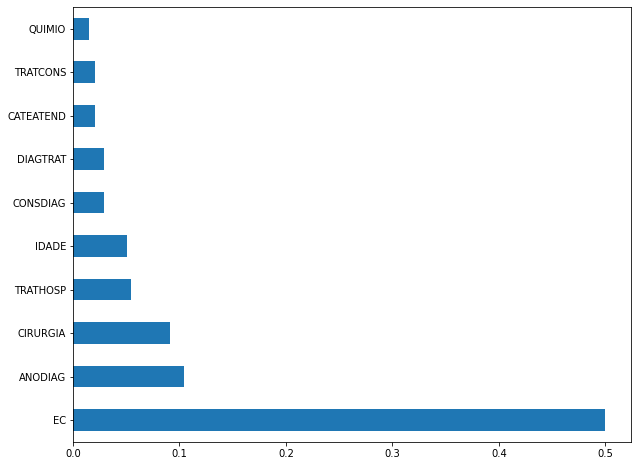

In [ ]:
plot_feat_importances(rf, feat_cols)

> As features mais importantes nesta visualização são `EC`, com uma grande vantagem, `ANODIAG`, `CIRURGIA` e `TRATHOSP`. 

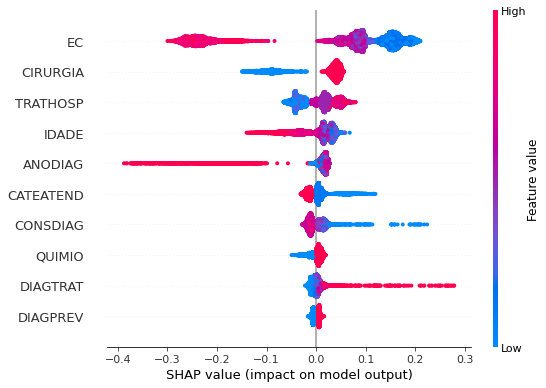

In [ ]:
plot_shap_values(rf, X_train, feat_cols)

A coluna `EC` foi a mais importante aqui também, com isso, os valores mais altos desta variável, mostrados em rosa, influenciaram mais o modelo na previsão da classe 0 (não sobreviveu ao terceiro ano após o diagnóstico). Já os valores mais baixos desta coluna, em azul, tem mais peso para previsão ser da classe 1. Este comportamento faz sentido, pois quanto mais alto o estágio, maior é a extensão do câncer, assim menor a chance de sobrevivência.

O raciocínio para analisar as outras colunas é o mesmo utilizado para o estadiamento clínico.

In [ ]:
tsne = TSNE(n_components=3, random_state=seed, perplexity=50)
tsne_results = tsne.fit_transform(X_test)

df_results = pd.DataFrame()
df_results['tsne_one'] = tsne_results[:, 0]
df_results['tsne_two'] = tsne_results[:, 1]
df_results['tsne_three'] = tsne_results[:, 2]
df_results['y_true'] = y_test.reset_index(drop=True)
df_results['y_pred'] = rf.predict(X_test)

In [ ]:
fig = px.scatter_3d(df_results, x='tsne_one', y='tsne_two', 
                    z='tsne_three', color=df_results.y_pred.astype(str),
                    height=600, width=950)

fig.update_traces(marker=dict(size=5, line=dict(width=0.7, 
                                                color='white')),
                  selector=dict(mode='markers'))

fig.show()

#### Optuna

Para fazer a busca pelos melhores hiperparâmetros, será utilizado a biblioteca Optuna, definindo o intervalo para os parâmetros do modelo a serem buscados.

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

In [ ]:
# Função com o modelos e seus parâmetros, que terá sua métrica maximizada 
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 3, 18)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples, 
                                 criterion=optimizer,
                                 random_state=seed)

    return cross_val_score(cls, X_train, y_train, 
                           cv=skf, scoring='balanced_accuracy').mean()

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100)

In [ ]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=19, state=TrialState.COMPLETE, values=[0.7653298572918547], datetime_start=datetime.datetime(2023, 2, 23, 12, 10, 51, 625028), datetime_complete=datetime.datetime(2023, 2, 23, 12, 11, 25, 746276), params={'n_estimators': 126, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.8999999999999999, 'criterion': 'entropy'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=1), 'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=19, value=None)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 126,
 'max_depth': 17,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_samples': 0.8999999999999999,
 'criterion': 'entropy'}

In [ ]:
plot_optimization_history(studyRF).show()

In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0: 1.725, 1: 1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1.725, 1: 1}, criterion='entropy',
                       max_depth=17, max_samples=0.8999999999999999,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=126, random_state=10)

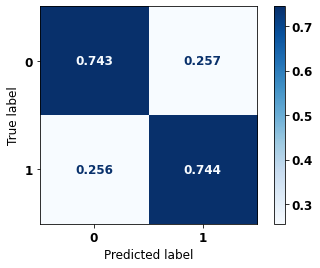


              precision    recall  f1-score   support

           0      0.728     0.743     0.736      3148
           1      0.758     0.744     0.751      3410

    accuracy                          0.744      6558
   macro avg      0.743     0.744     0.743      6558
weighted avg      0.744     0.744     0.744      6558



In [ ]:
# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

> Há uma melhora de acurácia em relação ao primeiro modelo testado, passando um pouco de 74%.

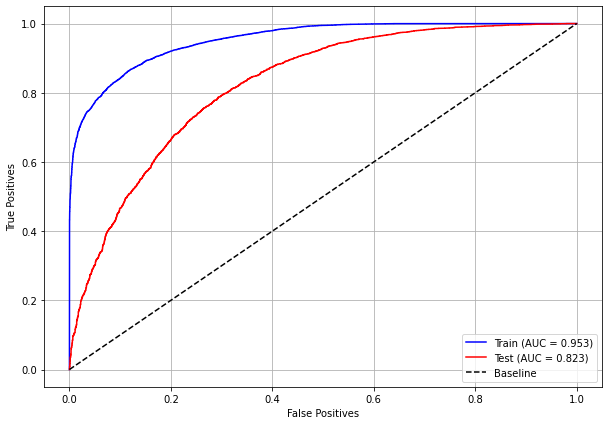

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui overfitting, pois para o conjunto de treino temos AUC = 0,953 e para o teste AUC = 0,823, essa diferença caracteriza o problema.

#### Randomized Search

O outro método é o de busca em grade aleatório, RandomizedSearchCV, a diferença é que serão testados somente os valores escolhidos para os parâmetros. O parâmetro `n_iter` define a quantidade de tentativas que serão feitas pela busca.

In [ ]:
# RandomizedSearchCV
hyperRF = {'n_estimators': [100, 150, 200, 250],
           'max_depth': [5, 8, 10, 15, 18],
           'min_samples_split': [2, 5, 10, 15, 25],
           'min_samples_leaf': [1, 2, 5, 10]} 

model = RandomForestClassifier(random_state=seed, criterion='entropy')

rscv = RandomizedSearchCV(model, hyperRF, n_iter=100, cv=skf,
                          random_state=seed)

In [ ]:
# Busca pelos parâmetros
bestRF = rscv.fit(X_train, y_train)

In [ ]:
bestRF.best_params_

In [ ]:
# Treinamento do modelo otimizado pelo RandomizedSearchCV
rf_opt = bestRF.best_estimator_
rf_opt.set_params(class_weight={0: 1.88, 1: 1})

rf_opt.fit(X_train, y_train)

In [ ]:
# Matriz de confusão do modelo otimizado pelo RandomizedSearchCV
plot_confusion_matrix(rf_opt, X_test, y_test)

> Há uma melhora de acurácia em relação ao primeiro modelo testado, de 76% para 77%.

In [ ]:
# Curva ROC do modelo otimizado pelo RandomizedSearchCV
plot_roc_curve(rf_opt, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui overfitting, pois para o conjunto de treino temos AUC = 0,974 e para o teste AUC = 0,844, essa diferença caracteriza o problema.

### **XGBoost**


O modelo XGBoost também terá alguns hiperparâmetros definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

* `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável `seed`.

* `max_depth`: será definido como 5, pois o padrão do modelo é 3 de profundidade máxima para as árvores, deixando o modelo muito simples.

* `scale_pos_weight`: usado para definir o peso da classe 1 no treinamento do modelo, pois temos classes desbalanceadas.

In [ ]:
# Criação e treinamento do modelo XGBoost 
xgboost = XGBClassifier(max_depth=5,
                        scale_pos_weight=0.706,
                        random_state=seed)

xgboost.fit(X_train, y_train)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=0.706)

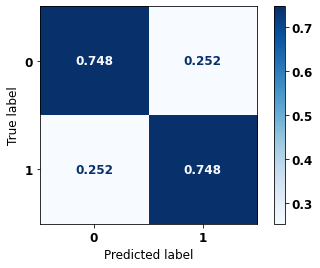


              precision    recall  f1-score   support

           0      0.733     0.748     0.740      3148
           1      0.763     0.748     0.755      3410

    accuracy                          0.748      6558
   macro avg      0.748     0.748     0.748      6558
weighted avg      0.748     0.748     0.748      6558



In [ ]:
# Matriz de confusão
plot_confusion_matrix(xgboost, X_test, y_test)

> A matriz obtida para o modelo XGBoost apresentou diagonal equilibrada em ambas as classes, com 75% de acurácia.


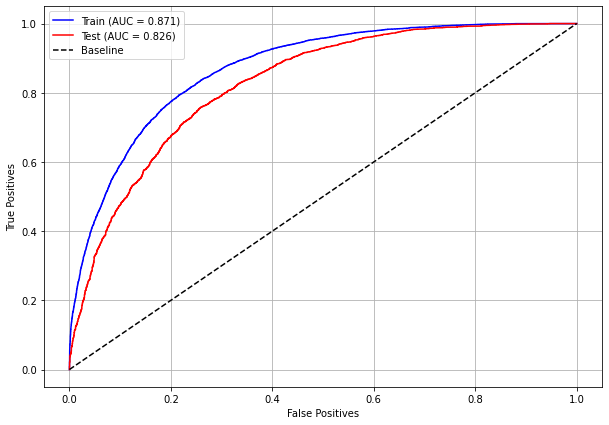

In [ ]:
# Curva ROC
plot_roc_curve(xgboost, X_train, X_test, y_train, y_test)

> Como a métrica AUC possui valores próximos para o conjunto de treino e de teste, 0,871 e 0,826 respectivamente, pode-se dizer que há apenas um pouco de overfitting, não sendo algo de grande preocupação.

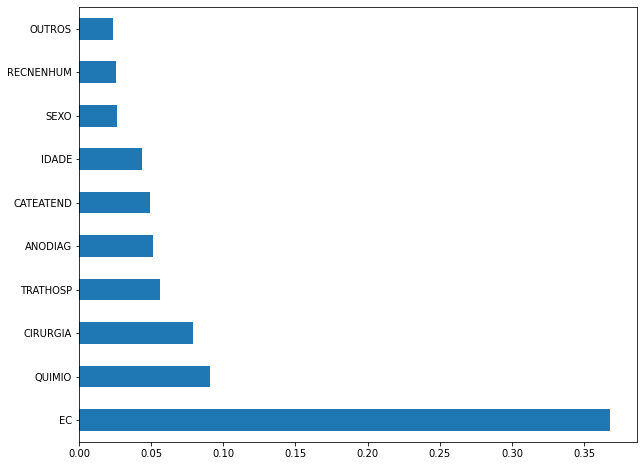

In [ ]:
# Importância das features
plot_feat_importances(xgboost, feat_cols)

> As features mais importantes nesta visualização são `EC`, com boa vantagem, `QUIMIO`, `CIRURGIA` e `TRATHOSP`. 

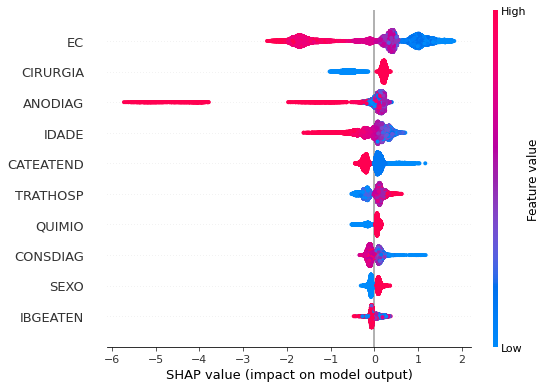

In [ ]:
# Importância das features pelo valores SHAP
plot_shap_values(xgboost, X_train, feat_cols)

A coluna `EC` foi a mais importante aqui também, com isso, os valores mais altos desta variável, mostrados em rosa, influenciaram mais o modelo na previsão da classe 0 (não sobreviveu ao terceiro ano após o diagnóstico). Já os valores mais baixos desta coluna, em azul, tem mais peso para previsão ser da classe 1. Este comportamento faz sentido, pois quanto mais alto o estágio, maior é a extensão do câncer, assim menor a chance de sobrevivência.

O raciocínio para analisar as outras colunas é o mesmo utilizado para o estadiamento clínico.

In [ ]:
df_results = pd.DataFrame()
df_results['tsne_one'] = tsne_results[:, 0]
df_results['tsne_two'] = tsne_results[:, 1]
df_results['tsne_three'] = tsne_results[:, 2]
df_results['y_true'] = y_test.reset_index(drop=True)
df_results['y_pred'] = xgboost.predict(X_test)

In [ ]:
fig = px.scatter_3d(df_results, x='tsne_one', y='tsne_two', 
                    z='tsne_three', color=df_results.y_pred.astype(str),
                    height=600, width=950)

fig.update_traces(marker=dict(size=5, line=dict(width=0.7, 
                                                color='white')),
                  selector=dict(mode='markers'))

fig.show()

#### Optuna

Para fazer a busca pelos melhores hiperparâmetros, será utilizado a biblioteca Optuna, definindo o intervalo para os parâmetros do modelo a serem buscados.

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

In [ ]:
# Função com o modelos e seus parâmetros, que terá sua métrica maximizada 
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 3, 18)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators, 
                        max_depth=max_depth, 
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight, 
                        colsample_bytree=colsample_bytree,
                        random_state=seed)

    return cross_val_score(cls, X_train, y_train, 
                           cv=skf, scoring='balanced_accuracy').mean()

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100)

In [ ]:
# Melhor tentativa
studyXGB.best_trial

FrozenTrial(number=52, state=TrialState.COMPLETE, values=[0.7667623153444152], datetime_start=datetime.datetime(2023, 2, 23, 13, 34, 13, 939453), datetime_complete=datetime.datetime(2023, 2, 23, 13, 34, 34, 918551), params={'n_estimators': 209, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.3, 'min_child_weight': 4, 'colsample_bytree': 0.3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=1), 'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=52, value=None)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 209,
 'max_depth': 3,
 'learning_rate': 0.2,
 'gamma': 0.3,
 'min_child_weight': 4,
 'colsample_bytree': 0.3}

In [ ]:
plot_optimization_history(studyXGB).show()

In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.72

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.3, gamma=0.3, learning_rate=0.2,
              min_child_weight=4, n_estimators=209, random_state=10,
              scale_pos_weight=0.72)

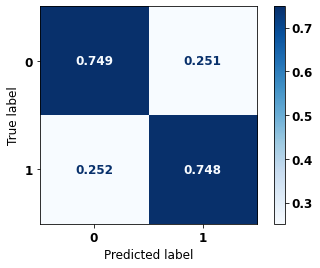


              precision    recall  f1-score   support

           0      0.733     0.749     0.741      3148
           1      0.763     0.748     0.755      3410

    accuracy                          0.748      6558
   macro avg      0.748     0.748     0.748      6558
weighted avg      0.749     0.748     0.748      6558



In [ ]:
# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

> Após a escolha dos hiperparâmetros, a acurácia de ambos os modelos ficou em torno de 75%.

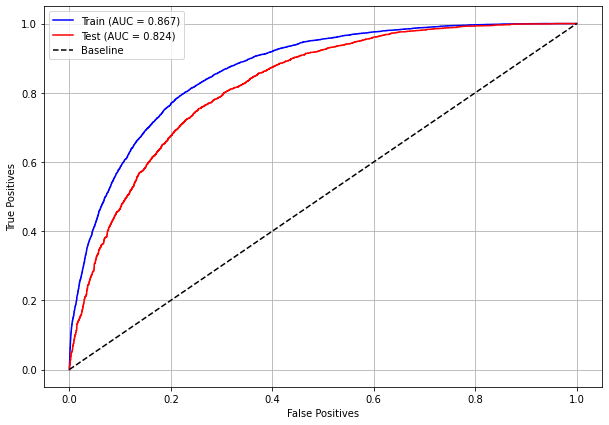

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui um pouco de overfitting, pois para o conjunto de treino temos AUC = 0,867 e para o teste AUC = 0,824, essa diferença caracteriza o problema.

#### Randomized Search

O outro método é o de busca em grade aleatório, RandomizedSearchCV, a diferença é que serão testados somente os valores escolhidos para os parâmetros. O parâmetro `n_iter` define a quantidade de tentativas que serão feitas pela busca.

In [ ]:
# RandomizedSearchCV
hyperXGB = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25],
            'max_depth': [5, 8, 10, 12, 15, 18],
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.0, 0.1, 0.2 , 0.3],
            'colsample_bytree': [0.3, 0.4, 0.5 , 0.7],
            'n_estimators': [50, 100, 150, 200, 250]}

model = XGBClassifier(random_state=seed)

rscv = RandomizedSearchCV(model, hyperXGB, n_iter=100, cv=skf,
                          random_state=seed)

In [ ]:
# Busca pelos parâmetros
bestXGB = rscv.fit(X_train, y_train)

In [ ]:
# Melhores parâmetros encontrados
bestXGB.best_params_

In [ ]:
# Treinamento do modelo otimizado pelo RandomizedSearchCV
xgb_opt = bestXGB.best_estimator_
xgb_opt.set_params(scale_pos_weight=0.695)

xgb_opt.fit(X_train, y_train)

In [ ]:
# Matriz de confusão do modelo otimizado pelo RandomizedSearchCV
plot_confusion_matrix(xgb_opt, X_test, y_test)

> Há uma melhora de acurácia em relação ao primeiro modelo testado, de 76% para 77%.

In [ ]:
# Curva ROC do modelo otimizado pelo RandomizedSearchCV
plot_roc_curve(xgb_opt, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui overfitting, pois para o conjunto de treino temos AUC = 0,974 e para o teste AUC = 0,844, essa diferença caracteriza o problema.

### **LightGBM**


O modelo LightGBM também terá alguns hiperparâmetros definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

* `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável `seed`.

* `max_depth`: será definido como 5, pois o padrão do modelo é 3 de profundidade máxima para as árvores, deixando o modelo muito simples.

* `class_weight`: usado para definir os pesos de cada classe no treinamento do modelo quando têm-se classes desbalanceadas.

In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=5, 
                      class_weight={0: 1.4, 1: 1},
                      random_state=seed)

lgbm.fit(X_train, y_train)

LGBMClassifier(class_weight={0: 1.4, 1: 1}, max_depth=5, random_state=10)

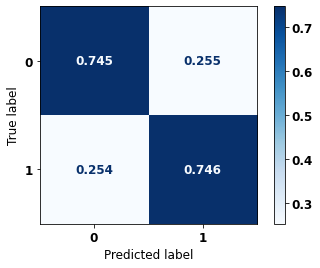


              precision    recall  f1-score   support

           0      0.730     0.745     0.737      3148
           1      0.760     0.746     0.753      3410

    accuracy                          0.745      6558
   macro avg      0.745     0.745     0.745      6558
weighted avg      0.746     0.745     0.745      6558



In [ ]:
# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

> A matriz obtida para o modelo LightGBM apresentou diagonal equilibrada em ambas as classes, com 74% de acurácia.


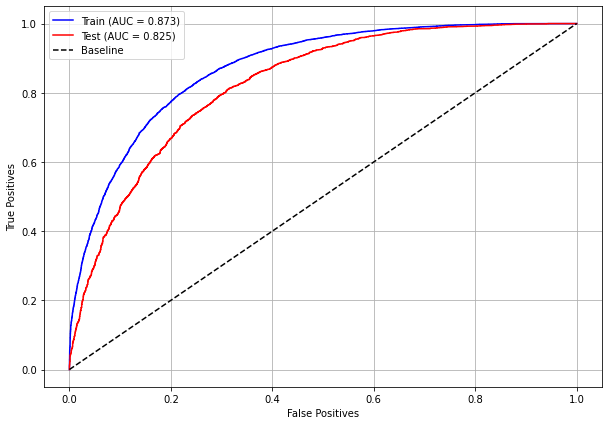

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

> Como a métrica AUC possui valores próximos para o conjunto de treino e de teste, 0,873 e 0,825 respectivamente, pode-se dizer que há apenas um pouco de overfitting.

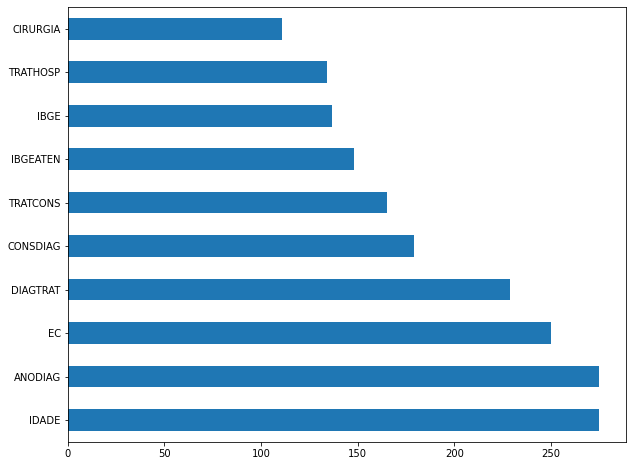

In [ ]:
# Importância das features
plot_feat_importances(lgbm, feat_cols)

> As features mais importantes nesta visualização são `IDADE`, `ANODIAG`, `EC` e `DIAGTRAT`. 

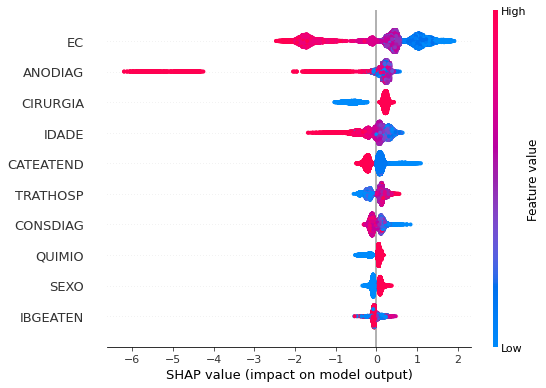

In [ ]:
# Importância das features pelo valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

A coluna `EC` foi a mais importante, com isso, os valores mais altos desta variável, mostrados em rosa, influenciaram mais o modelo na previsão da classe 0 (não sobreviveu ao terceiro ano após o diagnóstico). Já os valores mais baixos desta coluna, em azul, tem mais peso para previsão ser da classe 1. Este comportamento faz sentido, pois quanto mais alto o estágio, maior é a extensão do câncer, assim menor a chance de sobrevivência.

O raciocínio para analisar as outras colunas é o mesmo utilizado para o estadiamento clínico.

In [ ]:
df_results = pd.DataFrame()
df_results['tsne_one'] = tsne_results[:, 0]
df_results['tsne_two'] = tsne_results[:, 1]
df_results['tsne_three'] = tsne_results[:, 2]
df_results['y_true'] = y_test.reset_index(drop=True)
df_results['y_pred'] = lgbm.predict(X_test)

In [ ]:
fig = px.scatter_3d(df_results, x='tsne_one', y='tsne_two', 
                    z='tsne_three', color=df_results.y_pred.astype(str),
                    height=600, width=950)

fig.update_traces(marker=dict(size=5, line=dict(width=0.7, 
                                                color='white')),
                  selector=dict(mode='markers'))

fig.show()

#### Optuna

Para fazer a busca pelos melhores hiperparâmetros, será utilizado a biblioteca Optuna, definindo o intervalo para os parâmetros do modelo a serem buscados.

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

In [ ]:
# Função com o modelos e seus parâmetros, que terá sua métrica maximizada 
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 3, 18)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators, 
                         max_depth=max_depth, 
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed)

    return cross_val_score(cls, X_train, y_train, 
                           cv=skf, scoring='balanced_accuracy').mean()

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100)

In [ ]:
# Melhor tentativa
studyLGBM.best_trial

FrozenTrial(number=16, state=TrialState.COMPLETE, values=[0.7681864494330416], datetime_start=datetime.datetime(2023, 2, 23, 14, 20, 20, 810036), datetime_complete=datetime.datetime(2023, 2, 23, 14, 20, 25, 726159), params={'n_estimators': 171, 'max_depth': 11, 'learning_rate': 0.14, 'min_child_weight': 2, 'colsample_bytree': 0.4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=1), 'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.01), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=16, value=None)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 171,
 'max_depth': 11,
 'learning_rate': 0.14,
 'min_child_weight': 2,
 'colsample_bytree': 0.4}

In [ ]:
plot_optimization_history(studyLGBM).show()

In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0: 1.44, 1: 1}

lgbm_optuna = LGBMClassifier()
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

LGBMClassifier(class_weight={0: 1.44, 1: 1}, colsample_bytree=0.4,
               learning_rate=0.14, max_depth=11, min_child_weight=2,
               n_estimators=171, random_state=10)

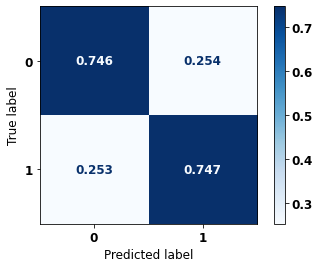


              precision    recall  f1-score   support

           0      0.731     0.746     0.738      3148
           1      0.761     0.747     0.754      3410

    accuracy                          0.746      6558
   macro avg      0.746     0.746     0.746      6558
weighted avg      0.747     0.746     0.746      6558



In [ ]:
# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

> Há uma melhora de acurácia em relação ao primeiro modelo testado, de 74% para 75%.

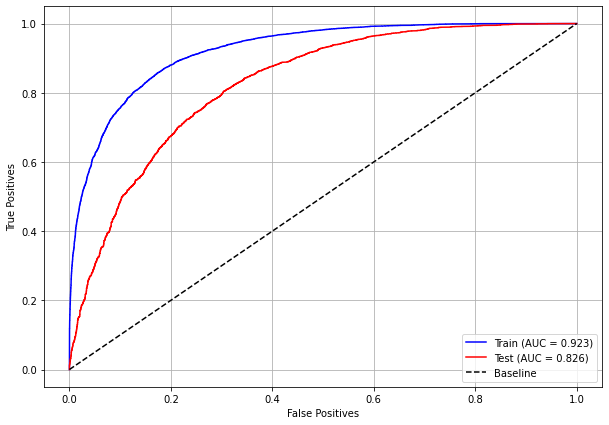

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui um pouco de overfitting, pois para o conjunto de treino temos AUC = 0,923 e para o teste AUC = 0,826, essa diferença caracteriza o problema.

### **Voting Classifier**


Usando os melhores modelos obtidos anteriormente, será criado um modelo de votação buscando obter um performance ainda melhor do que com os modelos sozinhos.

In [ ]:
# Melhores hiperparâmetros do modelo Random Forest
rf_score = rf.score(X_test, y_test)
optuna_score = rf_optuna.score(X_test, y_test)
print(f'Accuracy: RF = {rf_score}, Optuna = {optuna_score}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= rf_score:
    params_rf = rf_optuna.get_params()
    print('Otimizado venceu')
else:
    params_rf = rf.get_params()
    print('Modelo inicial venceu')

Accuracy: RF = 0.7380298871607197, Optuna = 0.7436718511741385

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgboost.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score}, Optuna = {optuna_score}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgboost.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7480939310765478, Optuna = 0.7482464165904239

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score}, Optuna = {optuna_score}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7453491918267765, Optuna = 0.7464165904239097

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# Random Forest
best_rf = RandomForestClassifier()
best_rf.set_params(**params_rf)

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1.44, 1: 1}, colsample_bytree=0.4,
               learning_rate=0.14, max_depth=11, min_child_weight=2,
               n_estimators=171, random_state=10)

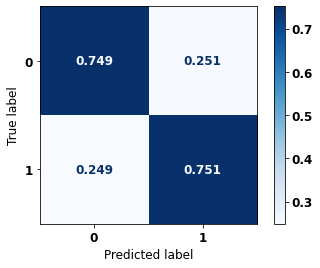


              precision    recall  f1-score   support

           0      0.735     0.749     0.742      3148
           1      0.764     0.751     0.758      3410

    accuracy                          0.750      6558
   macro avg      0.750     0.750     0.750      6558
weighted avg      0.750     0.750     0.750      6558



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('RandomForest', best_rf), 
                                   ('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ], 
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

> O modelo utilizando votação, com Random Forest, XGBoost e LightGBM, obteve resultados um pouco melhores em relação aos modelos sozinhos, com 75% de acurácia.

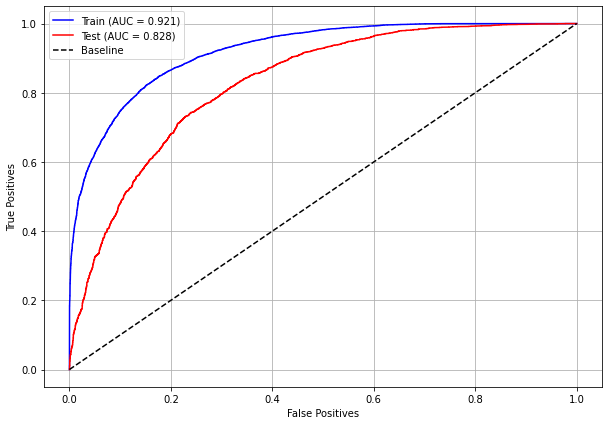

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui overfitting, pois para o conjunto de treino temos AUC = 0,921 e para o teste AUC = 0,828.

### **ROCs**

In [ ]:
roc_together(X_train, y_train, nb, rf, xgboost, lgbm_optuna)

In [ ]:
roc_together(X_test, y_test, nb, rf, xgboost, lgbm_optuna)

## **RN**

### **Importação das bibliotecas e funções**

In [ ]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Add, Input, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Definição de cores para gráficos
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
def plot_metrics(history):
    """Plot metrics after training the RNA.

    :param history: RNA training history.

    :return: no value
    :rtype: none
    """
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(12,8))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+ metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        if metric == 'accuracy':
            plt.ylim([0.7, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

### **Criação e treinamento da RNA**

In [ ]:
# Função que cria o bloco para a RN residual
def bloco_residual(x, n):
    
    z1 = Dense(n, activation='relu', kernel_regularizer=l2())(x)
    z2 = Dense(n, kernel_regularizer=l2())(z1)
    sum = Add()([x, z2])
    a2 = Activation('relu')(sum)

    return a2

In [ ]:
neg, pos = np.bincount(y_train)
total = neg + pos
print(f'Exemplos:\n Total: {total}\n Positivos: {pos} ({100*pos/total:.2f}% do total)')

# Cálculo dos pesos das duas classe
weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0

# Dicionário de pesos das classes para treinamento
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Peso da classe 0: {:.2f}'.format(weight_for_0))
print('Peso da classe 1: {:.2f}'.format(weight_for_1))

In [ ]:
input_shape = X_train.shape[1:]
input_features = Input(shape=input_shape, name='input_features')

x1 = Dense(128, activation='tanh', kernel_regularizer=l2())(input_features)
x2 = Dense(128, activation='selu', kernel_regularizer=l2())(input_features)
x3 = Dense(128, activation='sigmoid', kernel_regularizer=l2())(input_features)

from tensorflow.keras.layers import Concatenate
x_concat = Concatenate()([x1, x2, x3, input_features])

x4 = Dense(32, activation='relu', kernel_regularizer=l2())(x_concat)
out = Dense(1, activation='sigmoid', name='out_dense')(x4)

model = keras.Model(inputs=[input_features],
                    outputs=[out])

model.summary()

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Define métricas
METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

call_es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy',
              metrics=METRICS)

history = model.fit(X_train, y_train, epochs=50, 
                    class_weight=class_weight, 
                    verbose=2, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[call_es])

### **Resultados**

In [ ]:
plot_metrics(history)

In [ ]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('Número de exemplos positivos do conjunto de teste =', len(y_test[y_test > 0.9]))
results = model.evaluate(X_test, y_test, verbose=0)

for name, value in zip(model.metrics_names, results):
    print(f'{name}: {value:.4f}')

In [ ]:
precision = results[2]
recall = results[3]
F1 = 2*precision*recall/(precision + recall)
print(f'Pontuação F1 = {F1:.4f}')

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, np.round(test_pred), 
                                        normalize='true', cmap='Blues',
                                        values_format='.3f')
plt.show()

In [ ]:
fp_train, tp_train, _ = roc_curve(y_train, train_pred)
fp_test, tp_test, _ = roc_curve(y_test, test_pred)
plt.figure(figsize=(8, 6))
plt.plot(100*fp_train, 100*tp_train, 'b', label='Dados treinamento')
plt.plot(100*fp_test, 100*tp_test, 'r', label='Dados teste')
plt.xlabel('Positivos falsos [%]')
plt.ylabel('Positivos verdadeiros [%]')
plt.xlim([0,100])
plt.ylim([0,100])
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
custo_e_metricas_train = model.evaluate(X_train, y_train)
# custo_e_metricas_val = rna_reg.evaluate(X_val_norm, y_val)
custo_e_metricas_test = model.evaluate(X_test, y_test)

# **Second approach**

Approach with grouped years and without the column `ECGRUP`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets.

First, it is necessary to define the columns that will be used as features and the label. It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `EC` and not the column `ECGRUP`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 'obito_geral', 
             'vivo_ano1', 'vivo_ano5', 'ULTINFO', 'obito_cancer', 'ECGRUP', 'ESCOLARI']

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, 
                                                                                                last_year=2003, random_state=seed, 
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, 
                                                                                                last_year=2007, random_state=seed, 
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, 
                                                                                                last_year=2011, random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, 
                                                                                                last_year=2015, random_state=seed, 
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, 
                                                                                                last_year=2021, random_state=seed, 
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Naive Bayes**

The first model that will be tested is Naive Bayes.

In [ ]:
nb_sp_00_03 = GaussianNB()
nb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

In [ ]:
plot_confusion_matrix(nb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Naive Bayes, with the data from 2000 to 2003, shows a bad performance of the model, because we have an imbalanced main diagonal in the confusion matrix. The model predicted almost all the examples for the class 0.


In [ ]:
plot_roc_curve(nb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

In [ ]:
nb_sp_04_07 = GaussianNB()
nb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

In [ ]:
plot_confusion_matrix(nb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Naive Bayes, with the data from 2004 to 2007, shows a bad performance of the model, because we have an imbalanced main diagonal in the confusion matrix. The model predicted almost all the examples for the class 0.


In [ ]:
plot_roc_curve(nb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

In [ ]:
nb_sp_08_11 = GaussianNB()
nb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

In [ ]:
plot_confusion_matrix(nb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Naive Bayes, with the data from 2008 to 2011, shows a bad performance of the model, because we have an imbalanced main diagonal in the confusion matrix. The model predicted all the examples for the class 1.


In [ ]:
plot_roc_curve(nb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

In [ ]:
nb_sp_12_15 = GaussianNB()
nb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

In [ ]:
plot_confusion_matrix(nb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Naive Bayes, with the data from 2012 to 2015, shows a bad performance of the model, because we have an imbalanced main diagonal in the confusion matrix. 


In [ ]:
plot_roc_curve(nb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

In [ ]:
nb_sp_16_21 = GaussianNB()
nb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

In [ ]:
plot_confusion_matrix(nb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Naive Bayes, with the data from 2016 to 2021, shows a bad performance of the model, because we have an imbalanced main diagonal in the confusion matrix. 


In [ ]:
plot_roc_curve(nb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

### **Random Forest**


The second model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used, because the models still have difficulty to learn the class with fewer examples.

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.2, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with the data from 2000 to 2003, shows a good performance of the model, with 76% of accuracy.


In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `EC`, with a good advantage, `IDADE`, `TRATCONS`, and `CONSDIAG`. 

In [ ]:
plot_shap_values(rf_sp_00_03, X_trainSP_00_03, feat_SP_00_03)

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.855, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with the data from 2004 to 2007, shows a good performance of the model, with 72% of accuracy.

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `EC`, with a good advantage, `IDADE`, `CONSDIAG` and `TRATCONS`.

In [ ]:
plot_shap_values(rf_sp_04_07, X_trainSP_04_07, feat_SP_04_07)

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed,
                                     class_weight={0:2.2, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with the data from 2008 to 2011, shows a good performance of the model, with 74% of accuray.

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `EC`, with a good advantage, `IDADE`, `CONSDIAG` and `DIAGTRAT`.

In [ ]:
plot_shap_values(rf_sp_08_11, X_trainSP_08_11, feat_SP_08_11)

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.895, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with the data from 2012 to 2015, shows a good performance of the model with 74% of accuracy.

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `EC`, with a good advantage, `IDADE`, `CIRURGIA` and `CONSDIAG`.

In [ ]:
plot_shap_values(rf_sp_12_15, X_trainSP_12_15, feat_SP_12_15)

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:2},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

In [ ]:
plot_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Random Forest, with the data from 2016 to 2021, shows a good performance of the model, with 81% of accuracy.

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

In [ ]:
plot_roc_curve(rf_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `EC`, `ANODIAG`, `CIRURGIA`, and `IDADE`.



In [ ]:
plot_shap_values(rf_sp_16_21, X_trainSP_16_21, feat_SP_16_21)

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in some trainings, in order to obtain a balanced main diagonal in the confusion matrix.

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = XGBClassifier(max_depth=3, 
                                 random_state=seed, 
                                 scale_pos_weight=0.888)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with the data from 2000 to 2003, shows a good performance of the model, here with 75% of accuracy.

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `EC`, with a lot of advantage over the others. Following we have `QUIMIO`, `CATEATEND` and `TRATHOSP`.

In [ ]:
plot_shap_values(xgb_sp_00_03, X_trainSP_00_03, feat_SP_00_03)

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = XGBClassifier(max_depth=3, 
                                 random_state=seed, 
                                 scale_pos_weight=0.66)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with the data from 2004 to 2007, shows a good performance of the model, with 72% of accuracy.


In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `EC`, with a good advantage over the others. Following we have `TRATHOSP`, `CIRURGIA` and `IDADE`. 

In [ ]:
plot_shap_values(xgb_sp_04_07, X_trainSP_04_07, feat_SP_04_07)

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = XGBClassifier(max_depth=3, 
                                 scale_pos_weight=0.59,
                                 random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with the data from 2008 to 2011, shows a good performance of the model, with 75% of accuracy.

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `EC`, with a good advantage over the others. Following we have `QUIMIO`, `CATEATEND` and `IDADE`. 

In [ ]:
plot_shap_values(xgb_sp_08_11, X_trainSP_08_11, feat_SP_08_11)

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = XGBClassifier(max_depth=3, 
                                 random_state=seed,
                                 scale_pos_weight=0.63)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with the data from 2012 to 2015, shows a good performance of the model, with 74% of accuracy.

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `EC`, with a good advantage. Following we have `CIRURGIA`, `DIAGPREV` and `QUIMIO`. 

In [ ]:
plot_shap_values(xgb_sp_12_15, X_trainSP_12_15, feat_SP_12_15)

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = XGBClassifier(max_depth=3,
                                 random_state=seed, 
                                 scale_pos_weight=1.58)

xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

In [ ]:
plot_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the XGBoost, with the data from 2016 to 2021, shows a good performance of the model, with 81% of accuracy.


In [ ]:
plot_roc_curve(xgb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features were `EC`, `ANODIAG`, `CIRURGIA` and `TRATHOSP`.

In [ ]:
plot_shap_values(xgb_sp_16_21, X_trainSP_16_21, feat_SP_16_21)

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Naive Bayes SP for years 2000 to 2003**

In [ ]:
plot_confusion_matrix(nb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

In [ ]:
plot_confusion_matrix(nb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

In [ ]:
plot_confusion_matrix(nb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

In [ ]:
plot_confusion_matrix(nb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Naive Bayes SP for years 2004 to 2007**

In [ ]:
plot_confusion_matrix(nb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

In [ ]:
plot_confusion_matrix(nb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

In [ ]:
plot_confusion_matrix(nb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Naive Bayes SP for years 2008 to 2011**

In [ ]:
plot_confusion_matrix(nb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

In [ ]:
plot_confusion_matrix(nb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Naive Bayes SP for years 2012 to 2015**

In [ ]:
plot_confusion_matrix(nb_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2000 to 2003**

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2004 to 2007**

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2008 to 2011**

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2012 to 2015**

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2000 to 2003**

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2004 to 2007**

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2008 to 2011**

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2012 to 2015**

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21)